In [1]:
import warnings

warnings.filterwarnings("ignore")

import os.path
import ssm
import pickle
import numpy as np
import pandas as pd
import scipy
import copy
from tqdm import tqdm

from runwise_ts_log_data import get_ts_log_data_blocked

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import seaborn as sns

from sympy.utilities.iterables import multiset_permutations
from ssm.util import *
from scipy.stats import ttest_ind, wilcoxon, ranksums,ttest_1samp,spearmanr
from scipy.signal import find_peaks

from nilearn.image import load_img, new_img_like
from nilearn.plotting import plot_img_on_surf

from scipy.spatial.distance import cdist
import rle
import awkward as ak


In [2]:
maxrois = pd.read_csv('/home/joyneelm/emoprox2_slds_bootstrap_resamples/README_MAX_ROIs_final_gm_85.txt',sep='\t')

In [3]:
with open('pkl/emoprox2_dataset_timeseries+inputs_MAX85.pkl','rb') as f:
    orig_df = pickle.load(f)
subj_list = sorted(orig_df['pid'].unique())
# subj_list = subj_list[:] # remove first 30 subjects
orig_df = orig_df[orig_df['pid'].isin(subj_list)]

In [4]:
K = 6
D = 10
N = 85
num_subjs = 92
M=20
num_resamples = 500

In [5]:
with open(f'pkl/all_dfs_models_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
    all_dfs,all_models = pickle.load(f)

In [6]:
with open(f'pkl/state_masks_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
    state_masks = pickle.load(f)

In [7]:
print(len(all_dfs),len(all_models),len(state_masks))

500 500 500


# ROI importances

In [8]:
for df,model,state_mask in tqdm(zip(all_dfs.values(),all_models.values(),state_masks.values())):
    As = model.dynamics.As
    bs = model.dynamics.bs
    C = model.emissions.Cs[0]
    d = model.emissions.ds[0]
    Cinv = np.linalg.pinv(C) 
    Ahat_columnnorm = np.zeros((K,N))
    for idx_state in range(K):
        # y_{t} = C x_{t} + d
        # x_{t+1} = A x_{t} + b
        # y_{t+1} = C x_{t+1} + d = C (A x_{t} + b) + d = C A Cinv y_{t} + C b + d
        Ahat_columnnorm[idx_state,:] = np.linalg.norm(C@As[idx_state]@Cinv,axis=0)
    Ahat_columnnorm_shuffled = Ahat_columnnorm.copy()
    Ahat_columnnorm_shuffled = Ahat_columnnorm_shuffled[:,np.random.permutation(N)]

    df['roi_importance'] = [None]*df.shape[0]
    df['null_roi_importance'] = [None]*df.shape[0]
    for idx_row,row in df.iterrows():
        y = row['timeseries']
        z = row['discrete_states']

        df.at[idx_row,'roi_importance'] = np.multiply(abs(y),Ahat_columnnorm[z,:])
        df.at[idx_row,'null_roi_importance'] = np.multiply(abs(y),Ahat_columnnorm_shuffled[z,:])

500it [01:34,  5.27it/s]


In [9]:
# for df,model,state_mask in tqdm(zip(all_dfs.values(),all_models.values(),state_masks.values())):
#     As = model.dynamics.As
#     bs = model.dynamics.bs
#     V = model.dynamics.Vs
#     C = model.emissions.Cs[0]
#     d = model.emissions.ds[0]
#     Cinv = np.linalg.pinv(C) 
#     Vhat_statewise = np.zeros((K,N,M))
#     for idx_state in range(K):
#         # y_{t} = C x_{t} + d
#         # x_{t+1} = A x_{t} + b
#         # y_{t+1} = C x_{t+1} + d = C (A x_{t} + b) + d = C A Cinv y_{t} + C b + d
#         Ahat_columnnorm[idx_state,:] = np.linalg.norm(C@As[idx_state]@Cinv,axis=0)
#     Ahat_columnnorm_shuffled = Ahat_columnnorm.copy()
#     Ahat_columnnorm_shuffled = Ahat_columnnorm_shuffled[:,np.random.permutation(N)]

#     df['input_importance'] = [None]*df.shape[0]
#     for idx_row,row in df.iterrows():
#         y = row['timeseries']
#         z = row['discrete_states']

#         df.at[idx_row,'roi_importance'] = np.multiply(abs(y),Ahat_columnnorm[z,:])
#         df.at[idx_row,'null_roi_importance'] = np.multiply(abs(y),Ahat_columnnorm_shuffled[z,:])

In [10]:
    # Ahat_columnnorm_shuffled = Ahat_columnnorm.copy()
    # Ahat_columnnorm_shuffled = Ahat_columnnorm_shuffled[:,np.random.permutation(N)]

    # df['roi_importance'] = [None]*df.shape[0]
    # df['null_roi_importance'] = [None]*df.shape[0]
    # for idx_row,row in df.iterrows():
    #     y = row['timeseries']
    #     z = row['discrete_states']

    #     df.at[idx_row,'roi_importance'] = np.multiply(abs(y),Ahat_columnnorm[z,:])
    #     df.at[idx_row,'null_roi_importance'] = np.multiply(abs(y),Ahat_columnnorm_shuffled[z,:])

In [11]:
state_resps = {k:[] for k in range(K)}
state_bold = {k:[] for k in range(K)}
null_state_resps = {k:[] for k in range(K)}
for idx_resample in tqdm(range(1,101)):
    df = all_dfs[idx_resample]
    state_mask = state_masks[idx_resample]
    for idx_row,row in df.iterrows():
        y = row['roi_importance'].copy()
        y -= np.expand_dims(np.mean(y,axis=0),axis=0)
        y /= np.expand_dims(np.std(y,axis=0),axis=0)

        bold = row['timeseries']

        y1 = row['null_roi_importance'].copy()
        y1 -= np.expand_dims(np.mean(y1,axis=0),axis=0)
        y1 /= np.expand_dims(np.std(y1,axis=0),axis=0)
        
        z = row['discrete_states'].copy()
        states,durations = rle.encode(z)
        onsets = np.cumsum(np.concatenate((np.zeros(1),durations)))[:-1].astype('int')
        for state,onset,duration in zip(states,onsets,durations):
            if state_mask[state]==1: continue
            state_resps[state].append(y[onset:onset+duration,:])
            state_bold[state].append(bold[onset:onset+duration,:])
            null_state_resps[state].append(y1[onset:onset+duration,:])

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


In [12]:
mean_imps_all_states = []
mean_bold_all_states = []
for idx_state in range(K-1):
    dur = int(np.mean([y.shape[0] for y in state_resps[idx_state]]))
    mean_imps = ak.to_numpy(ak.mean(ak.Array(state_resps[idx_state]),axis=0))[:dur,:]
    mean_bold = ak.to_numpy(ak.mean(ak.Array(state_bold[idx_state]),axis=0))[:dur,:]
    mean_imps_all_states.append(mean_imps)
    mean_bold_all_states.append(mean_bold)

(6,)
(5,)
(16,)
(11,)
(6,)


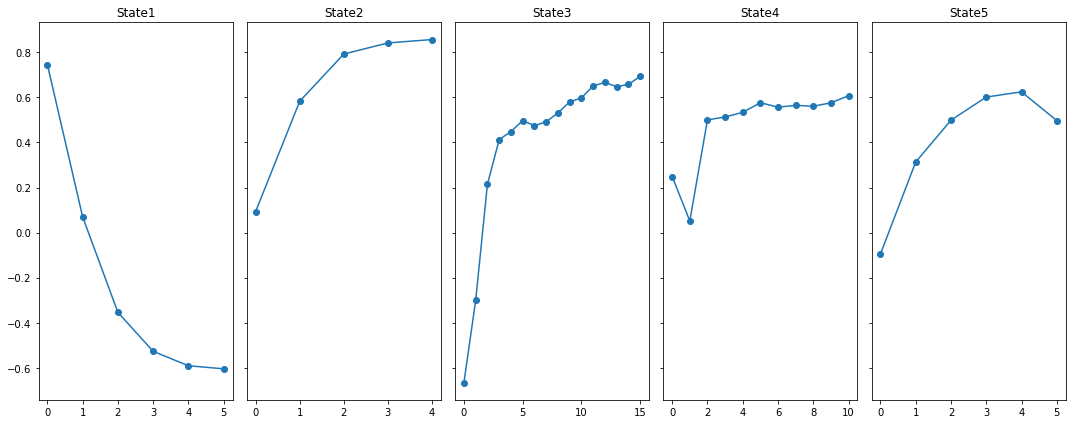

In [13]:
fig,axs = plt.subplots(1,K-1, figsize=(15,6),sharey=True)
for idx_state in range(K-1):
    mean_imps = mean_imps_all_states[idx_state]
    mean_bold = mean_bold_all_states[idx_state]
    dur = mean_imps.shape[0]
    corr_ts = np.zeros(dur)
    for t in range(dur):
        corr_ts[t] = np.corrcoef(mean_imps[t,:],mean_bold[t,:])[0,1]
    print(corr_ts.shape)
    ax = axs[idx_state]
    ax.plot(corr_ts,marker='o')
    ax.set_title(f'State{idx_state+1}')

fig.tight_layout()

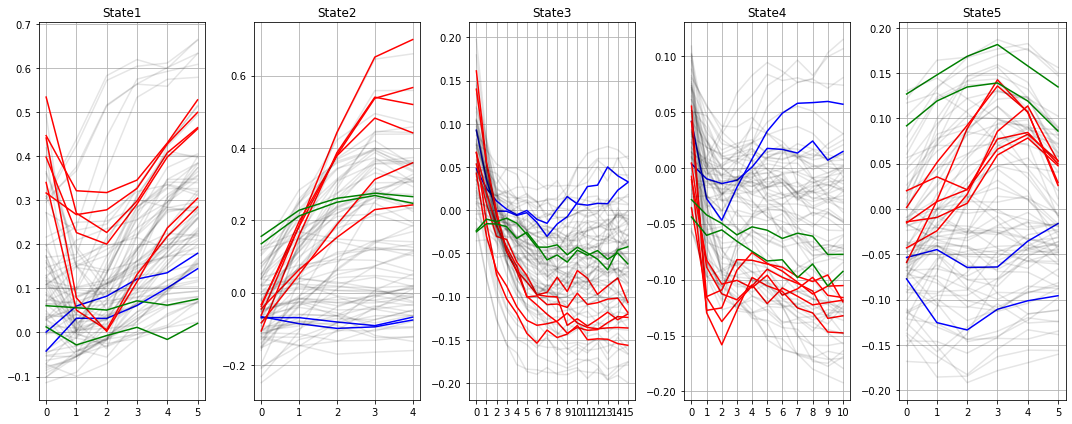

In [14]:
fig,axs = plt.subplots(1,K-1, figsize=(15,6))
for idx_state in range(K-1):
    mean_resps = mean_imps_all_states[idx_state]
    dur = mean_resps.shape[0]

    ax = axs[idx_state]
    for idx,row in maxrois.iterrows():
        roi = row['Hemi']+' '+row['ROI']
        idx_roi = row['Index']-1
        if "Insula" in roi:
            _ = ax.plot(mean_resps[:,idx_roi],label=roi,marker=None,color='r',alpha=1)
        elif  "vmPFC" in roi:
            _ = ax.plot(mean_resps[:,idx_roi],label=roi,marker=None,color='b',alpha=1)
        elif  "PAG" in roi:
            _ = ax.plot(mean_resps[:,idx_roi],label=roi,marker=None,color='g',alpha=1)
        else:
            _ = ax.plot(mean_resps[:,idx_roi],label=roi,marker=None,color='k',alpha=0.1)
            
    ax.set_title(f'State{idx_state+1}')
    ax.grid(True)
    ax.set_xticks(np.arange(dur))
fig.tight_layout()

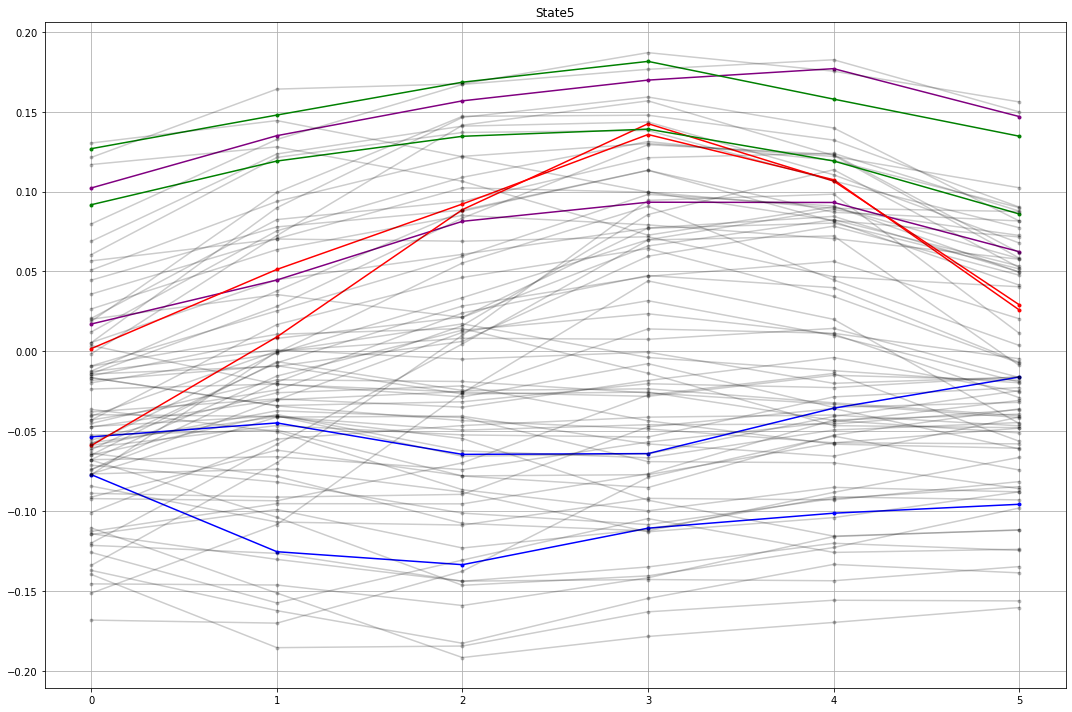

In [15]:
fig,axs = plt.subplots(1,1, figsize=(15,10))
for idx_state in [4]:
    mean_resps = mean_imps_all_states[idx_state]
    dur = mean_resps.shape[0]

    ax = axs
    for idx,row in maxrois.iterrows():
        roi = row['Hemi']+' '+row['ROI']
        idx_roi = row['Index']-1
        if "dorsal Insula" in roi:
            _ = ax.plot(mean_resps[:,idx_roi],label=roi,marker='.',color='r',alpha=1)
        elif  "vmPFC" in roi:
            _ = ax.plot(mean_resps[:,idx_roi],label=roi,marker='.',color='b',alpha=1)
        elif  "PAG" in roi:
            _ = ax.plot(mean_resps[:,idx_roi],label=roi,marker='.',color='g',alpha=1)
        elif  "post. Caudate" in roi:
            _ = ax.plot(mean_resps[:,idx_roi],label=roi,marker='.',color='purple',alpha=1)
        else:
            _ = ax.plot(mean_resps[:,idx_roi],label=roi,marker='.',color='k',alpha=0.2)
            
    ax.set_title(f'State{idx_state+1}')
    ax.grid(True)
    ax.set_xticks(np.arange(dur))
fig.tight_layout()

In [16]:
for idx_state in [4]:
    print(idx_state+1)
    mean_resps = mean_imps_all_states[idx_state]
    dur = mean_resps.shape[0]
    for t in range(dur):
        roinames = []
        for i in np.argsort(-mean_resps[t,:])[:20]:
            row = maxrois.iloc[i]
            roi = row['Hemi']+' '+row['ROI']
            roinames.append(roi)
        print(f't={t}',roinames)

5
t=0 ['R CrusI-krienen', 'L PAG', 'L CrusI-shackman', 'L CrusI-krienen', 'R post. Caudate', 'R PAG', 'R CrusI-shackman', 'L  v med/post Thalamus', 'R v med/post Thalamus', 'L Hypothalamus', 'L v lat/post Thalamus', 'R v lat/post Thalamus', 'L BST', 'R BST', 'L post. Putamen', 'L ant. ventral Insula', 'L ant. Putamen', 'L post. Caudate', 'R post. Putamen', 'R dlPFC']
t=1 ['L CrusI-shackman', 'L PAG', 'R CrusI-krienen', 'R post. Caudate', 'R CrusI-shackman', 'L CrusI-krienen', 'L  v med/post Thalamus', 'R v med/post Thalamus', 'R PAG', 'L ant. Putamen', 'L v lat/post Thalamus', 'R ant. Putamen', 'L post. Putamen', 'R v lat/post Thalamus', 'R post. Putamen', 'R v ant/inf Thalamus', 'L BST', 'L Hypothalamus', 'R BST', 'L ant. dorsal Insula']
t=2 ['L PAG', 'L CrusI-shackman', 'R CrusI-shackman', 'R post. Caudate', 'L ant. Putamen', 'R ant. Putamen', 'R v ant/inf Thalamus', 'L  v med/post Thalamus', 'R v med/post Thalamus', 'R PAG', 'L v lat/post Thalamus', 'R CrusI-krienen', 'R post. Putam

In [17]:
for idx_state in range(K-1):
    print(idx_state+1)
    mean_resps = mean_imps_all_states[idx_state]
    dur = mean_resps.shape[0]   
    for t in range(dur):
        roinames = []
        for i in np.argsort(-mean_resps[t,:])[:20]:
            row = maxrois.iloc[i]
            roi = row['Hemi']+' '+row['ROI']
            roinames.append(roi)
        print(roinames)

1
['R ant. dorsal Insula', 'R ant. MCC', 'R ant. ventral Insula', 'R mid/post Insula', 'R IFG-5', 'R pre-SMA', 'L ant. MCC', 'L ant. dorsal Insula', 'R CrusI-shackman', 'R IFG-6', 'L mid/post Insula', 'L ant. ventral Insula', 'L CrusI-shackman', 'L ant. Putamen', 'R post. Putamen', 'R ant. Putamen', 'L post. Putamen', 'R ACC', 'R v ant/sup Thalamus', 'L Hippocampus body']
['L ant. Putamen', 'R ant. Putamen', 'L post. Putamen', 'R post. Putamen', 'R ant. ventral Insula', 'R ant. dorsal Insula', 'L ant. ventral Insula', 'L Hippocampus body', 'L ant. Caudate', 'R ACC', 'L ant. dorsal Insula', 'R Hippocampus body', 'R CrusI-shackman', 'R IFG-6', 'R ant. Caudate', 'R CrusI-krienen', 'L ACC', 'L Hippocampus tail', 'L CrusI-shackman', 'R IFG-5']
['L ant. Putamen', 'R ant. Putamen', 'L post. Putamen', 'R post. Putamen', 'L ant. Caudate', 'R ant. Caudate', 'R ant. ventral Insula', 'L ant. ventral Insula', 'R FEF', 'L Hippocampus body', 'R ACC', 'R Hippocampus body', 'R ant. dorsal Insula', 'L F

In [19]:
def vec2img(vec:np.ndarray):
    atlasimg = load_img('/home/joyneelm/templates/MAX_ROIs_final_gm_85.nii.gz')
    atlasdata = atlasimg.get_fdata()
    nrois = vec.shape[0]
    retdata = np.zeros_like(atlasdata)
    for idx_roi in range(nrois):
        retdata[atlasdata==(idx_roi+1)] = vec[idx_roi]
    ret = new_img_like(ref_niimg=atlasimg,data=retdata)
    return ret

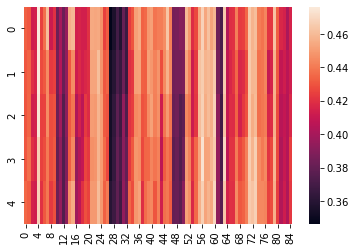

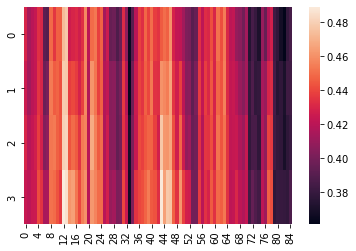

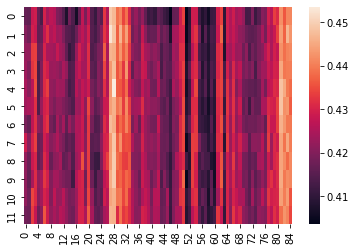

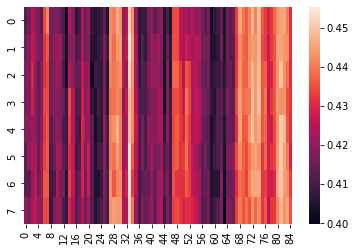

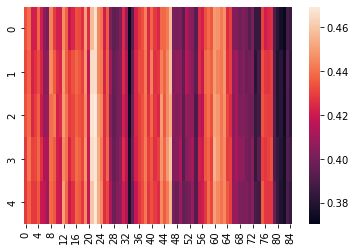

In [20]:
mean_resps_threshed = {}
pvals_all = {}
for idx_state in range(K-1):
    dur = int(np.median([y.shape[0] for y in state_resps[idx_state]]))
    mean_resps = ak.to_numpy(ak.mean(ak.Array(state_resps[idx_state]),axis=0))[:dur,:]
    pvals = np.ones_like(mean_resps)
    for t in range(dur):
        null_vals = np.stack([x[t,:] for x in null_state_resps[idx_state] if len(x)>t])
        true_vals = mean_resps[t,:]
        for idx_roi in range(N):
            pvals[t,idx_roi] = (null_vals[:,idx_roi]>true_vals[idx_roi]).mean()
        # print(null_vals.shape, true_vals.shape)
    pvals_all[idx_state] = pvals
    mean_resps_threshed[idx_state] = mean_resps
    fig = plt.figure()
    sns.heatmap(pvals)

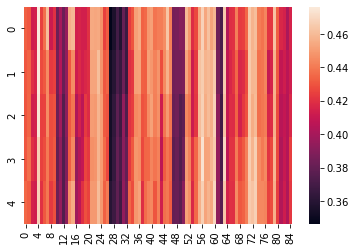

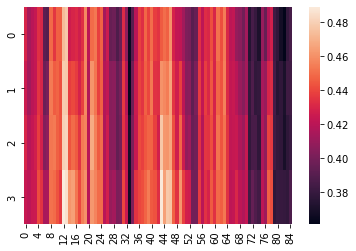

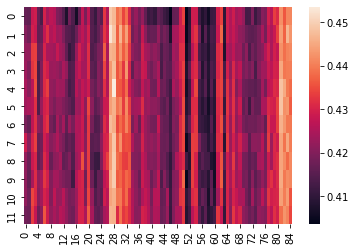

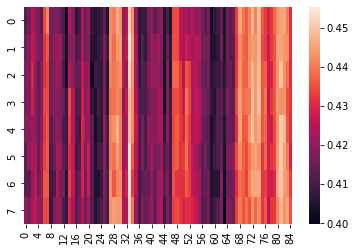

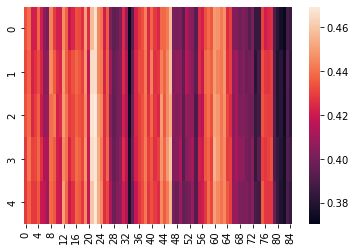

In [23]:
for idx_state in range(K-1):
    fig = plt.figure()
    sns.heatmap(pvals_all[idx_state])

(5, 85)
(4, 85)
(12, 85)
(8, 85)
(5, 85)


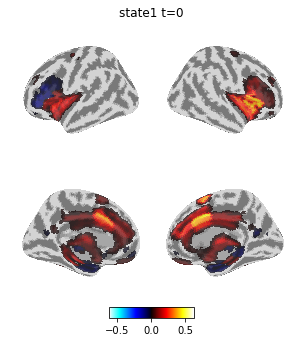

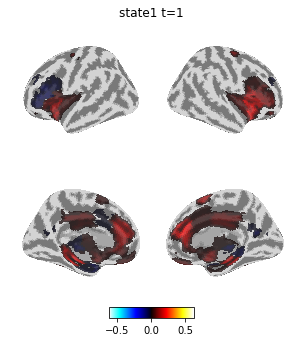

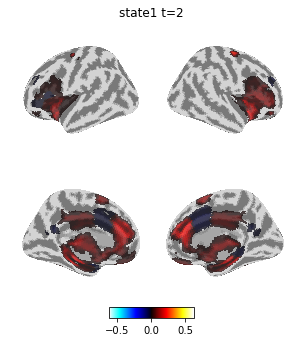

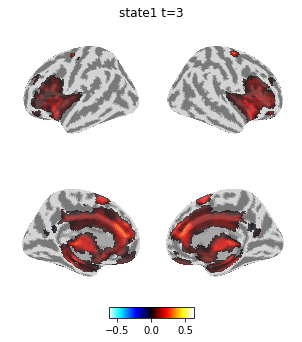

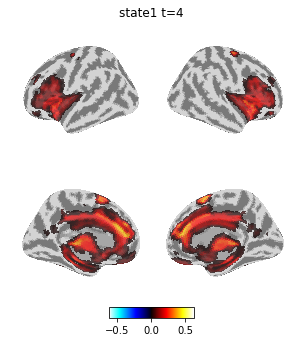

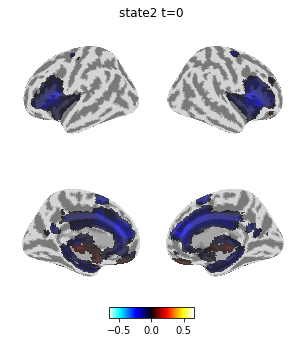

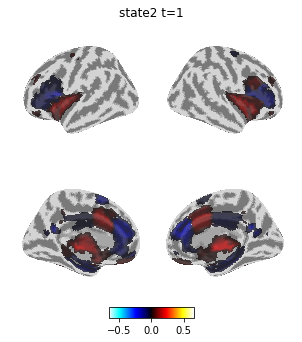

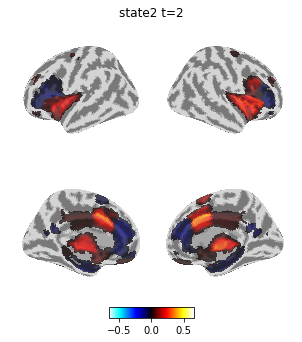

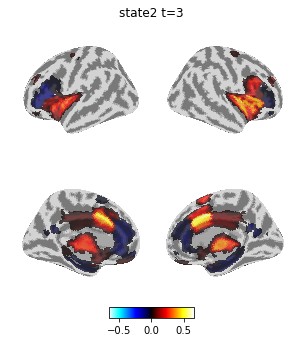

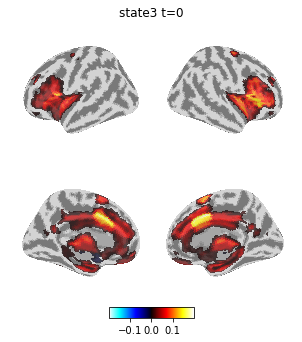

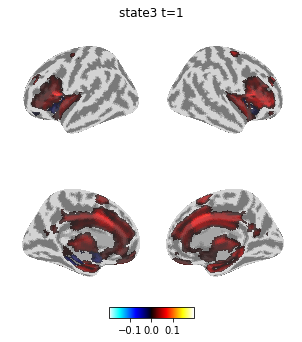

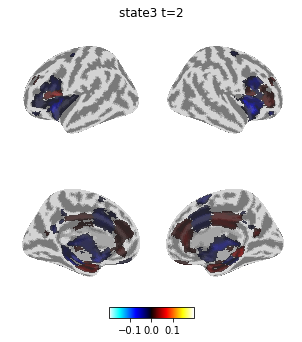

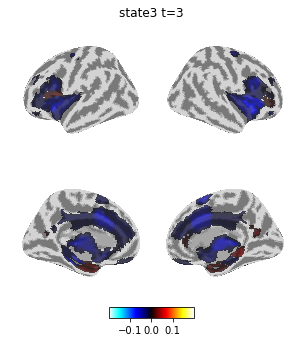

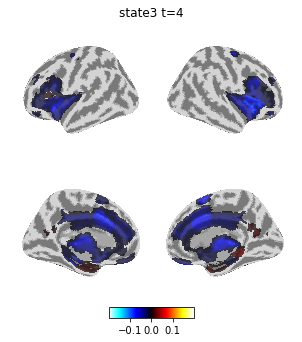

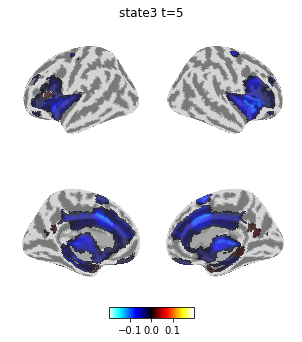

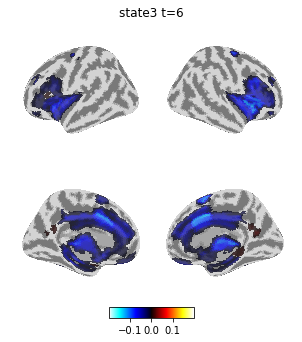

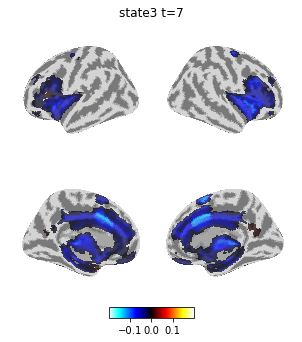

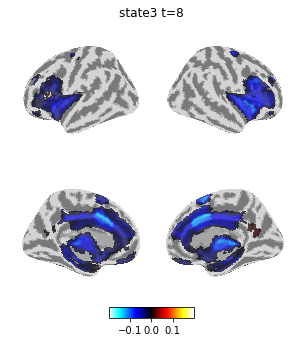

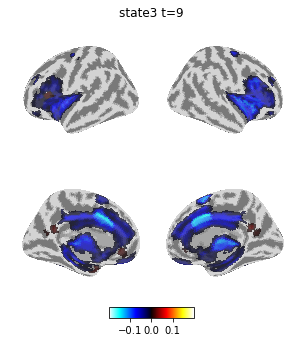

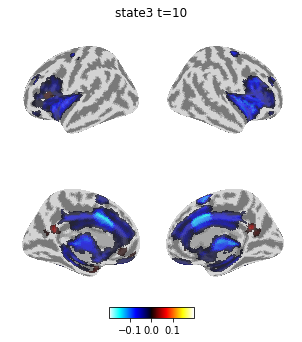

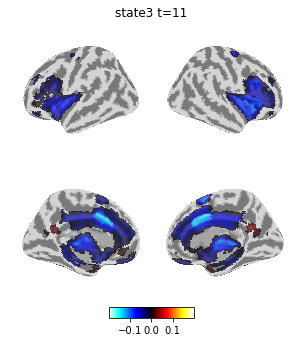

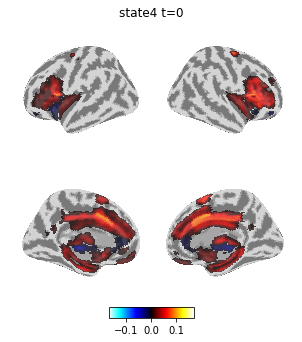

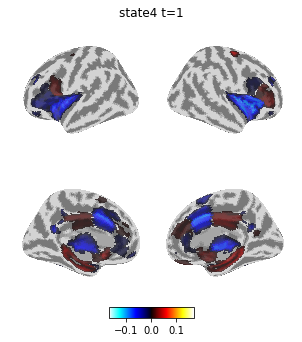

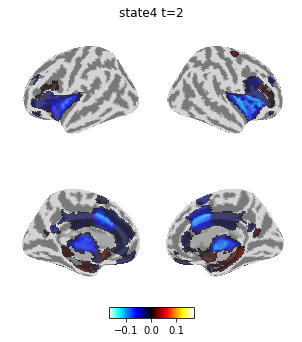

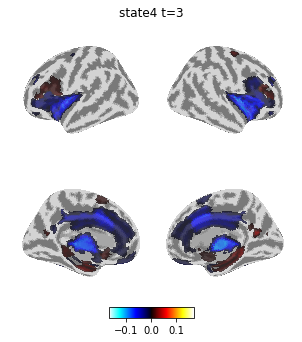

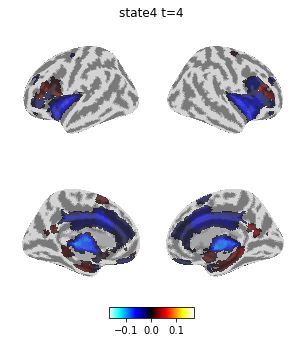

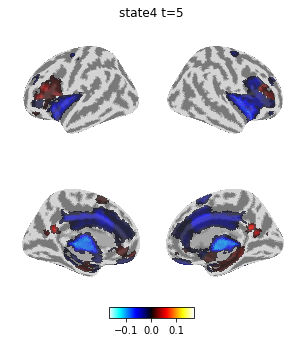

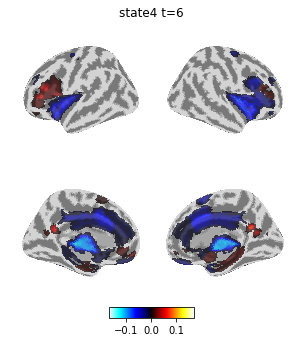

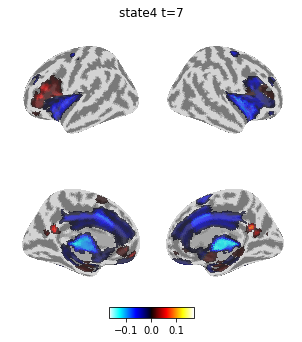

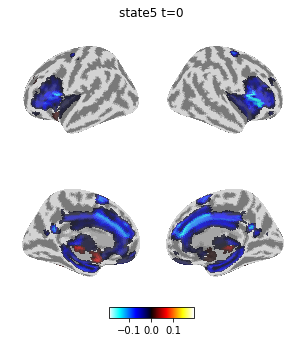

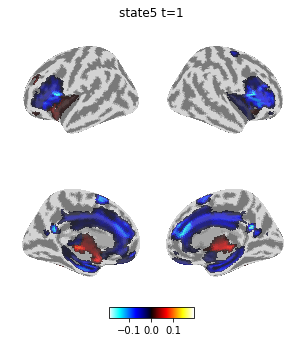

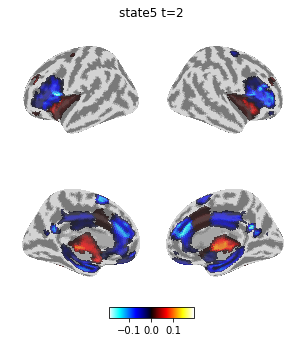

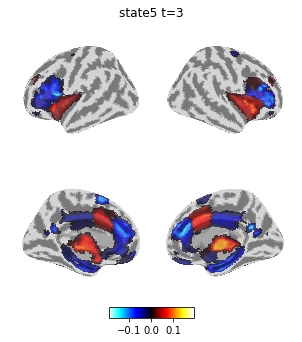

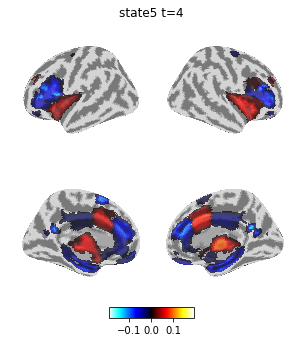

In [15]:
for idx_state in range(K-1):
    # dur = int(np.median([y.shape[0] for y in state_resps[idx_state]]))
    # mean_resps = ak.to_numpy(ak.mean(ak.Array(state_resps[idx_state]),axis=0))[:dur,:]
    mean_resps = mean_resps_threshed[idx_state].copy()
    pvals = pvals_all[idx_state].copy()
    
    print(mean_resps.shape)
    for t in range(mean_resps.shape[0]):
        img = vec2img(mean_resps[t,:])
        # plot_stat_map(img)
        fig,ax = plot_img_on_surf(
            stat_map=img,
            views=["lateral", "medial"],
            hemispheres=["left", "right"],
            colorbar=True,
            inflate=True,
            threshold=0.001,
            vmax=np.abs(mean_resps).max(),
            title=f'state{idx_state+1} t={t}',
            bg_on_data=True,
        )
        fig.savefig(f'./roi_importance/state{idx_state+1}_t={t+1}_thresh.png',dpi=300,bbox_inches='tight',facecolor='white', transparent=False)

In [29]:
def ts2img(ts:np.ndarray):
    atlasimg = load_img('/home/joyneelm/templates/MAX_ROIs_final_gm_85.nii.gz')
    atlasdata = atlasimg.get_fdata()
    vols = []
    for t in range(ts.shape[0]):
        vec = ts[t,:]
        nrois = vec.shape[0]
        retdata = np.zeros(atlasdata.shape,dtype='float')
        for idx_roi in range(nrois):
            retdata[atlasdata==(idx_roi+1)] = vec[idx_roi]
        vols.append(retdata)
    vols = np.stack(vols,axis=-1)
    ret = new_img_like(ref_niimg=atlasimg,data=vols,copy_header=True)
    return ret

for idx_state in range(K-1):
    mean_resps = mean_imps_all_states[idx_state]
    dur = mean_resps.shape[0]
    img = ts2img(mean_resps)
    img.to_filename(f'roi_importance/roi_importance_state{idx_state+1}.nii.gz')